In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import math
from tqdm import tqdm as tqdm
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Neural Networks Model by TensorFlow

In [52]:
class tf_nn_model():
    def __init__(self, laysers_dims):
        self.laysers_dims = laysers_dims
        self.L = len(laysers_dims) - 1
        self.n_x = laysers_dims[0]
        self.n_y = laysers_dims[-1]
        self.W = [None for i in range(self.L+1)]
        self.b = [None for i in range(self.L+1)]
        self.initial_params()
        self.initial_palceholder()
        self.J = []
        
    def set_data(self, X, Y):
        self.X_run = X
        self.Y_run = Y
    
    def initial_params(self):
        for i in range(1, self.L+1):
            self.W[i] = tf.get_variable("W"+str(i), [self.laysers_dims[i], self.laysers_dims[i-1]],
                                         initializer = tf.contrib.layers.xavier_initializer())
            self.b[i] = tf.get_variable("b"+str(i), [self.laysers_dims[i], 1],
                                         initializer = tf.zeros_initializer())
    
    def initial_palceholder(self):
        self.X = tf.placeholder(tf.float32, [self.n_x, None])
        self.Y = tf.placeholder(tf.float32, [self.n_y, None])
    
    def forward(self):
        Z = tf.matmul(self.W[1], self.X) + self.b[1]
        A = tf.nn.relu(Z)
        for i in range(2, self.L+1):
            Z = tf.matmul(self.W[i], A) + self.b[i]
            A = tf.nn.relu(Z)
        return A
    
    def sess_start(self):
        self.sess = tf.Session()
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
    def sess_close(self):
        self.sess.close()
        
    def random_mini_batches(self, bs=64):  
        m = self.X_run.shape[1]              
        mini_batches = []
        # Shuffle (X, Y)
        permutation = list(np.random.permutation(m))
        shuffled_X = self.X_run[:, permutation]
        shuffled_Y = self.Y_run[:, permutation]
        # Partition (shuffled_X, shuffled_Y). Minus the end case.
        num_complete_minibatches = math.floor(m/bs) # number of mini batches of size mini_batch_size in your partitionning
        # Slice the batch into minibatch
        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[:, k * bs : k * bs + bs]
            mini_batch_Y = shuffled_Y[:, k * bs : k * bs + bs]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
        # Handling the end case (last mini-batch < mini_batch_size)
        if m % bs != 0:
            mini_batch_X = shuffled_X[:, num_complete_minibatches * bs : m]
            mini_batch_Y = shuffled_Y[:, num_complete_minibatches * bs : m]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        return mini_batches
    
    def run(self, lr=0.01, epoch=1000, bs=64):
        # forward
        self.Y_hat = self.forward()
        # cost function
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.transpose(self.Y), logits=tf.transpose(self.Y_hat)))
        # run optimization 
        train = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost)
        for epoch in tqdm(range(epoch)):
            # get the mini batchs
            mini_batches = self.random_mini_batches(bs)
            # run by mini batch
            for mini_batch in mini_batches:
                _, epoch_cost = self.sess.run([train, cost], feed_dict={self.X: mini_batch[0], self.Y: mini_batch[1]})
                self.J.append(epoch_cost)
        print('cost: ', epoch_cost)
        
    def train_accuracy(self):
        correct_prediction = tf.equal(tf.argmax(self.Y_hat), tf.argmax(self.Y))
        acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return self.sess.run(acc, feed_dict={self.X: self.X_run, self.Y: self.Y_run})
    
    def test_accuracy(self, X_test, Y_test):
        self.set_data(X_test, Y_test)
        self.Y_hat = self.forward()
        correct_prediction = tf.equal(tf.argmax(self.Y_hat), tf.argmax(self.Y))
        acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return self.sess.run(acc, feed_dict={self.X: self.X_run, self.Y: self.Y_run})

### MNIST Dataset

In [53]:
X_train = mnist.train.images.T[:, :1000]
Y_train = mnist.train.labels.T[:, :1000]
X_test = mnist.train.images.T[:, 1000: 1100]
Y_test = mnist.train.labels.T[:, 1000: 1100]

### NN with mini batch size as 64

100%|██████████| 1000/1000 [00:21<00:00, 47.51it/s]


cost:  0.134025
train accuracy:  0.988
test accuracy :  0.91
elapsed:  21.28191304206848


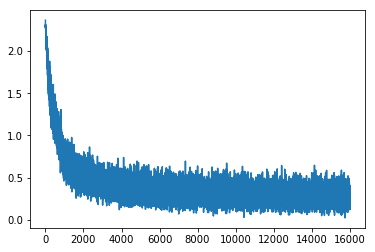

In [57]:
ops.reset_default_graph() 
tf_nn = tf_nn_model([X_train.shape[0], 50, Y_train.shape[0]])
tf_nn.set_data(X_train, Y_train)

start = time.time()
tf_nn.sess_start()
tf_nn.run(lr=0.01, epoch=1000, bs=64)
tf_nn.sess_close()
plt.plot(tf_nn.J)
print('train accuracy: ', tf_nn.train_accuracy())
print('test accuracy : ', tf_nn.test_accuracy(X_test, Y_test))
elapsed = time.time() - start
print('elapsed: ', elapsed)

### NN without mini batch

100%|██████████| 1000/1000 [00:11<00:00, 87.13it/s]


cost:  0.729042
train accuracy:  0.801
test accuracy :  0.84
elapsed:  11.815655946731567


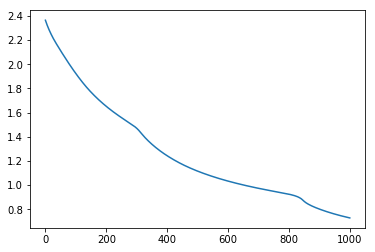

In [58]:
ops.reset_default_graph() 
tf_nn = tf_nn_model([X_train.shape[0], 50, Y_train.shape[0]])
tf_nn.set_data(X_train, Y_train)

start = time.time()
tf_nn.sess_start()
tf_nn.run(lr=0.01, epoch=1000, bs=X_train.shape[1])
tf_nn.sess_close()
plt.plot(tf_nn.J)
print('train accuracy: ', tf_nn.train_accuracy())
print('test accuracy : ', tf_nn.test_accuracy(X_test, Y_test))
elapsed = time.time() - start
print('elapsed: ', elapsed)